Train a network to solve the time or aiming angle given relative position and velocity.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split

device = "cuda" if torch.cuda.is_available() else 'cpu'
device = "cpu" # model is very simple, so CPU only could be faster than CPU+GPU, without data transmission between the two.
device

'cpu'

In [21]:
def display_error_curves(num_epochs, training_losses, validation_losses):
    plt.plot(range(1,num_epochs+1), training_losses, label="Training Loss")
    try:
        plt.plot(range(1,num_epochs+1), validation_losses, label="Validation Loss")
    except:pass
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.show()


class MLP_mhl_T(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP_mhl_T, self).__init__()
        self.linear1 = nn.Linear(input_size,hidden_sizes[0])
        self.relu = nn.ReLU()
        self.hidden = nn.ModuleList()
        for k in range(len(hidden_sizes)-1):
            self.hidden.append(nn.Linear(hidden_sizes[k], hidden_sizes[k+1]))
            self.hidden.append(nn.ReLU())
        self.linear2 = nn.Linear(hidden_sizes[-1],output_size)
    
    def forward(self, x):
        x = self.relu(self.linear1(x))
        for i, l in enumerate(self.hidden):
            x = l(x)
        x = self.relu(self.linear2(x))
        return x

class MLP_mhl_A(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP_mhl_A, self).__init__()
        self.linear1 = nn.Linear(input_size,hidden_sizes[0])
        self.relu = nn.ReLU()
        self.hidden = nn.ModuleList()
        for k in range(len(hidden_sizes)-1):
            self.hidden.append(nn.Linear(hidden_sizes[k], hidden_sizes[k+1]))
            self.hidden.append(nn.ReLU())
        self.linear2 = nn.Linear(hidden_sizes[-1],output_size)

    def forward(self, x):
        x = self.relu(self.linear1(x))
        for i, l in enumerate(self.hidden):
            x = l(x)
        x = self.linear2(x)
        return x


def train_MLP_cpu(model, train_loader, val_loader, loss_fn, optimizer, lr_gamma=0.9, num_epochs=10,showcurve=True):
    # Instantiate the model
    mlp = model

    scheduler = lr_scheduler.StepLR(optimizer, step_size=1,gamma=lr_gamma)
    v_num_batches = len(val_loader)
    train_err = []
    test_err = []

    # Train the model
    for n in range(num_epochs):
        mlp.train()
        tloss = []
        for batch, (X, y) in enumerate(train_loader):
            pred = mlp(X)
            loss = loss_fn(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            tloss.append(loss.cpu().detach().numpy())
        scheduler.step()
        train_err.append(np.mean(tloss))

        mlp.eval()
        test_loss = 0
        with torch.no_grad():
            for X, y in val_loader:
                pred = mlp(X)
                test_loss += loss_fn(pred, y).item()
        test_loss /= v_num_batches
        test_err.append(test_loss)
        print(f"Epoch: {str(n+1).zfill(4)}, Val Error: Avg loss: {test_loss:>8f}.",end='\r')
    if showcurve:
        # Display Loss Curves
        display_error_curves(num_epochs, train_err, test_err)
    
    return mlp, train_err,test_err

### Train for Time

In [29]:
# load data
data = np.load('data/ATdata_0_2400000_0.npy')
data = np.append(data,(np.sqrt(np.sum(data[:,:2]**2,axis=1))/3)[:,np.newaxis],axis=1) # Add a dummy prediction as |distance|/3
data[0]

array([134.1 , -33.9 ,   0.  ,   0.  ,   0.  ,  20.5 ,  64.5 ,  46.12],
      dtype=float16)

In [30]:
# get train/test
X,y = data[:,[0,1,-1]],data[:,[6]]
x_train, x_test, y_train, y_test = train_test_split(X,y,shuffle=True,random_state=0)
x_train.shape,y_train.shape

((1800000, 3), (1800000, 1))

In [31]:
# get dataloaders
dtype = torch.float32
batch_size = 128
loss_fn = nn.MSELoss()
trainset = torch.utils.data.TensorDataset(torch.Tensor(x_train).to(dtype),torch.Tensor(y_train).to(dtype))
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)
testset = torch.utils.data.TensorDataset(torch.Tensor(x_test).to(dtype),torch.Tensor(y_test).to(dtype))
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False)

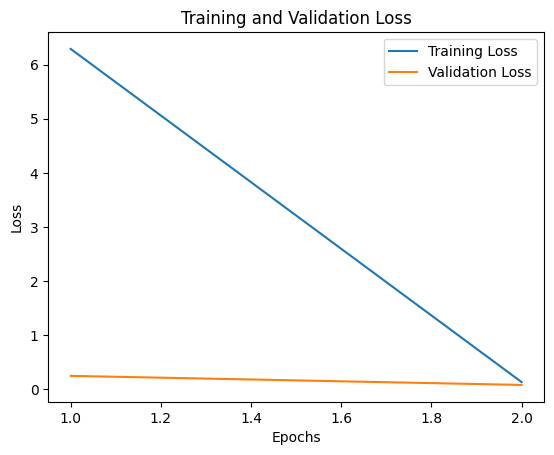

In [33]:
# train by initiate a model with custom hidden layers
mlp = MLP_mhl_T(x_train.shape[1],(16,8),1)
# OR load a model in progress
#    mlp = torch.jit.load('xxx')
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)
lr_decay = 0.9
n_epochs = 2
mlp, train_loss, test_loss = train_MLP_cpu(mlp,train_loader,test_loader,loss_fn,optimizer,lr_decay,n_epochs,True)

0.08242085


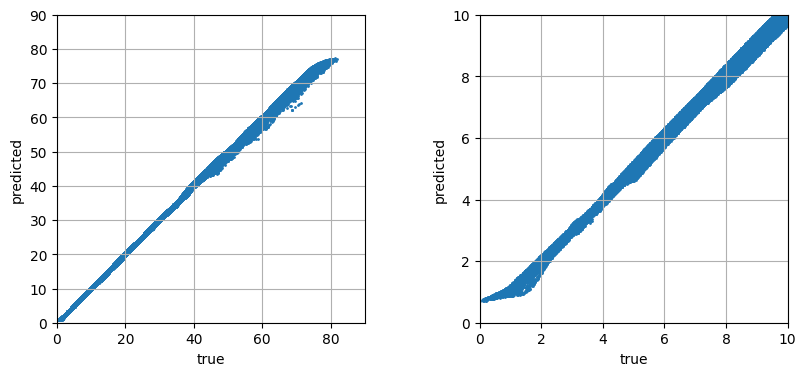

In [34]:
# plot test performance
mlp.eval()
device='cpu'
with torch.no_grad():
    X,y = testset.tensors[0],testset.tensors[1]
    pred = mlp(X)
    loss = loss_fn(pred, y).cpu().detach().numpy()
    pred = pred.cpu().detach().numpy()
    ytrue = y.cpu().detach().numpy()
print(loss)

fig,axes = plt.subplots(1,2,figsize=(10,4))
for ax in axes:
    ax.scatter(ytrue,pred,s=1)
    ax.set_xlabel('true')
    ax.set_ylabel('predicted')
    ax.grid()
    ax.set_aspect('equal')
axes[0].set_xlim(0,90)
axes[0].set_ylim(0,90)
axes[1].set_xlim(0,10)
axes[1].set_ylim(0,10)
plt.show()

In [35]:
# save model
model_scripted = torch.jit.script(mlp) # Export to TorchScript
model_scripted.save('model/xxx_t') # Save

### Train for pitch Angle

In [22]:
data = np.load('data/ATdata_0_2400000_0.npy')
data = np.append(data,np.rad2deg(np.arctan2(data[:,1],data[:,0])[:,np.newaxis]),axis=1) # Add a dummy prediction as arctan(y,R)
X,y = data[:,[0,1,-1]],data[:,[5]]
x_train, x_test, y_train, y_test = train_test_split(X,y,shuffle=True,random_state=0)
dtype = torch.float32
batch_size = 128
loss_fn = nn.MSELoss()
trainset = torch.utils.data.TensorDataset(torch.Tensor(x_train).to(dtype),torch.Tensor(y_train).to(dtype))
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)
testset = torch.utils.data.TensorDataset(torch.Tensor(x_test).to(dtype),torch.Tensor(y_test).to(dtype))
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False)
x_train.shape,y_train.shape

((1800000, 3), (1800000, 1))

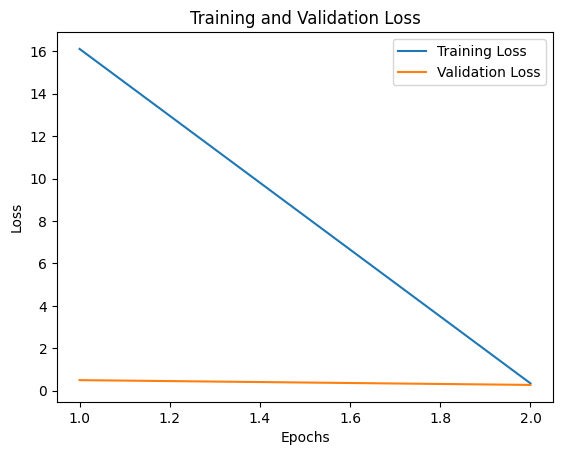

In [26]:
mlp = MLP_mhl_A(x_train.shape[1],(16,8),1)
# OR load if you train a loaded model
#    mlp = torch.jit.load('xxx')
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)
lr_decay = 0.9
n_epochs = 2
mlp, train_loss, test_loss = train_MLP_cpu(mlp,train_loader,test_loader,loss_fn,optimizer,lr_decay,n_epochs,True)

0.27468395


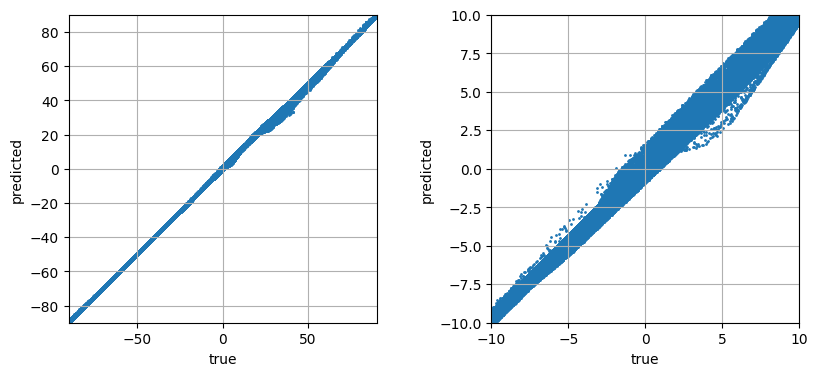

In [27]:
mlp.eval()
device='cpu'
with torch.no_grad():
    X,y = testset.tensors[0],testset.tensors[1]
    pred = mlp(X)
    loss = loss_fn(pred, y).cpu().detach().numpy()
    pred = pred.cpu().detach().numpy()
    ytrue = y.cpu().detach().numpy()
print(loss)

fig,axes = plt.subplots(1,2,figsize=(10,4))
for ax in axes:
    ax.scatter(ytrue,pred,s=1)
    ax.set_xlabel('true')
    ax.set_ylabel('predicted')
    ax.grid()
    ax.set_aspect('equal')
axes[0].set_xlim(-90,90)
axes[0].set_ylim(-90,90)
axes[1].set_xlim(-10,10)
axes[1].set_ylim(-10,10)
plt.show()

In [28]:
model_scripted = torch.jit.script(mlp) # Export to TorchScript
model_scripted.save('model/xxx_a') # Save